<a href="https://colab.research.google.com/github/jiin124/2021_2_SAI_ML/blob/main/12%EC%A3%BC%EC%B0%A8/%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EC%84%9D_%EC%8B%A4%EC%8A%B5_%EC%BA%90%EA%B8%80_mercari_price_suggestion_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
os.environ['KAGGLE_USERNAME']='jiinpp'
os.environ['KAGGLE_KEY']='b06d525a9f66198051ccb648b091778a'

In [4]:
from sklearn.linear_model import Ridge,LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(217374, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [5]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217374 entries, 0 to 217373
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           217374 non-null  int64  
 1   name               217374 non-null  object 
 2   item_condition_id  217374 non-null  int64  
 3   category_name      216443 non-null  object 
 4   brand_name         124449 non-null  object 
 5   price              217374 non-null  float64
 6   shipping           217374 non-null  int64  
 7   item_description   217374 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 13.3+ MB


NULL값이 너무 많음. 나중에 치환해야할것 같다. 

target값인 price 칼럼의 데이터 분포도를 살펴보겠다. 회귀에서 target값의 정규 분포도는 매우 중요하다. 왜곡되어있는 경우 보통 로그를 씌워서 변환하면 대부분 정규부포의 형태를 가지게 된다 먼저 price 칼럼의 데이터 값 분포도를 확인해보겠다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


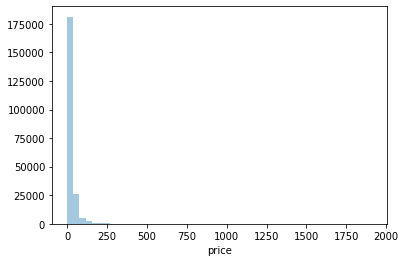

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

왜곡이 너무 심하다. price칼럼에 로그를 씌워서 분포도를 다시 살펴보겠다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


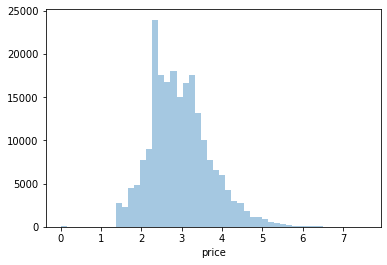

In [7]:
import numpy as np

y_train_df=np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

In [8]:
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [9]:
print('shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

shipping 값 유형:
 0    120306
1     97068
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    93690
3    63457
2    55228
4     4627
5      372
Name: item_condition_id, dtype: int64


shipping 칼럼은 배송비 유무이며, 값이 비교적 균일하다. item_condition_id는 판매자가 제공하는 제품 상태로서 각 값이 의미하는 바는 캐글에 기재되어있지 않아서 알수 없지만 1,2,3값이 주를 이루고 있다.

item_description 칼럼은 null값은 별로 없지만, discription에 대한 별도 설명이 없는 경우 'No description yet'값으로 되어있다. 이런 값이 얼마나 있는지 알아보겠다.

In [14]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

217374

적절한 값으로 변경해야한다. 
category_name을 살펴보겠다. category_name은 '\'로 분리되어 있다. 가령 Men/tops/t-shirt 는 대분류 Men 중분류 tops 소분류 t-shirts 로 나눌수 있다. category_name은 텍스트이므로, 피처추출시 tokenizer를 '\'를 기준으로 단어를 토근화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습시키겠다.

category_name칼럼은 null값을 약 6300여 건을 가지고 있으므로 이에 유의하면서 분리를 해내야 한다. 



In [16]:
#apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대중소 값을 리스트로 반환

def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other','Other_Null','Other_Null']

#위에 split_cat()을 apply lambda에서 호출해 대 중 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'],mercari_df['cat_jung'],mercari_df['cat_so']=zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

대분류만 갑스이 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출

In [17]:
print('대분류 유형:\n',mercari_df['cat_dae'].value_counts())
print('중분류 유형:\n',mercari_df['cat_jung'].nunique())
print('소분류 개수:',mercari_df['cat_so'].nunique())

대분류 유형:
 Women                     97548
Beauty                    30483
Kids                      25163
Electronics               17922
Men                       13830
Home                       9906
Other                      7621
Vintage & Collectibles     6756
Handmade                   4466
Sports & Outdoors          3679
Name: cat_dae, dtype: int64
중분류 유형:
 114
소분류 개수: 762


마지막으로 brand_name,category_name,item_description 칼럼의 null값은 일괓ㄹ적으로 'other null로 동일하게 변경하겠다. 

In [18]:
mercari_df['brand_name']=mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name']=mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description']=mercari_df['item_description'].fillna(value='Other_Null')


In [19]:
#각 칼럼별로 Null 값 건수 확인, 모두 0이 나와야 한다. 
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

## 피처 인코딩과 피처 벡터화

price 값을 예측해야 하므로 회귀 모델을 기반으로 해야한다. 선형회귀 모데과 회귀 트리 모델을 ㅁ두 적용할것이다. 특히 선형 회귀의 경우 원핫인코딩적용이 ㅎ러신 선호되므로 인코딩할 피처는 모두 원핫인코딩을 적용하겠다. 

비교적 짧은 텍스트의 경우 count기반의 벡터화, 긴텍스트는 tf-idf기반의 벡터화를 적용하겠다.

In [20]:
print('brand name의 유형건수:',mercari_df['brand_name'].nunique())
print('brand name sample 5건:',mercari_df['brand_name'].value_counts())

brand name의 유형건수: 2753
brand name sample 5건: Other_Null                 92925
PINK                        7984
Nike                        7822
Victoria's Secret           7088
LuLaRoe                     4601
                           ...  
Michael Antonio                1
Ronco                          1
Quantum Mechanix               1
Disney Interactive             1
Ralph Lauren Blue Label        1
Name: brand_name, Length: 2753, dtype: int64


In [22]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 199003
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [23]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 18.0


0    No description yet
1    No description yet
Name: item_description, dtype: object

In [24]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (217374, 37801)
item_description vectorization shape: (217374, 1)


In [25]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [26]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(217374, 2753), X_item_cond_id shape:(217374, 5)
X_shipping shape:(217374, 1), X_cat_dae shape:(217374, 10)
X_cat_jung shape:(217374, 114), X_cat_so shape:(217374, 762)


In [27]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (217374, 41447)


125

In [28]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [29]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

In [30]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5178556862010572
Item Description을 포함한 rmsle 값: 0.5179679082822248


In [31]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.5044205048232393


In [32]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4933162720750578
